In [3]:
from gan_synthesis.datasets.dataset import VAEMaskDataset


dataset = VAEMaskDataset()

train_dataset, test_dataset = dataset.split()

recon, mu, logvar = vae(input)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from gan_synthesis.mask_vae_models.encoder import Encoder
from gan_synthesis.mask_vae_models.decoder import Decoder
from gan_synthesis.mask_vae_models.vae import VAE, kl_divergence
from gan_synthesis.datasets.dataset import Dataset
from tqdm import tqdm



# TODO: add live matplotlib plotting
# TODO: add function to completely process kaggle dataset into fully processed 2D slices so can work on PC


# Instantiate data loaders
dataset = Dataset()
train_set, test_set = dataset.split(0.8)
train_loader = DataLoader(train_set, batch_size=2, shuffle=True)
test_loader = DataLoader(test_set, batch_size=2, shuffle=True)

# Instantiate models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = Encoder().to(device)
decoder = Decoder().to(device)
model = VAE(encoder, decoder).to(device)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# Before the loop
train_losses = []
val_losses = []
val_accuracies = []

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0

    for _, seg in tqdm(train_loader, desc="Training", leave=False):
        seg = seg.to(device)

        recon, mu, logvar = model(seg)
        kld_loss = kl_divergence(mu, logvar)
        ce_loss = criterion(recon, seg)
        loss = ce_loss + 5e-3 * kld_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    running_val_loss = 0.0
    correct, total = 0, 0

    with torch.no_grad():
        for _, seg in tqdm(test_loader, desc="Test", leave=False):
            seg = seg.to(device)
            recon, mu, logvar = model(seg)
            kld_loss = kl_divergence(mu, logvar)
            ce_loss = criterion(recon, seg)
            loss = ce_loss + 5e-3 * kld_loss
            running_val_loss += loss.item()

            pred = torch.argmax(recon, dim=1)
            correct += (pred == seg).sum().item()
            total += seg.numel()

    avg_val_loss = running_val_loss / len(test_loader)
    val_losses.append(avg_val_loss)

    acc = correct / total
    val_accuracies.append(acc)

    print(f"[Epoch {epoch+1}] Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {acc:.4f}")


ModuleNotFoundError: No module named 'tqdm'

In [11]:
from gan_synthesis.preprocessing.transforms import read_data
seg= read_data(1, "seg")

In [12]:
seg.shape

(240, 240)

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


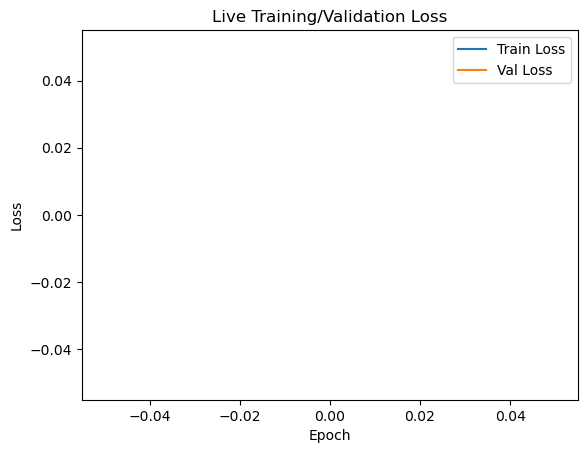

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from gan_synthesis.mask_vae_models.encoder import Encoder
from gan_synthesis.mask_vae_models.decoder import Decoder
from gan_synthesis.mask_vae_models.vae import VAE, kl_divergence
from gan_synthesis.datasets.dataset import Dataset
from tqdm import tqdm
import matplotlib.pyplot as plt

# Enable live plotting
plt.ion()
fig, ax = plt.subplots()
line1, = ax.plot([], [], label="Train Loss")
line2, = ax.plot([], [], label="Val Loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Live Training/Validation Loss")
ax.legend()

# Instantiate data loaders
dataset = Dataset()
train_set, test_set = dataset.split(0.8)
train_loader = DataLoader(train_set, batch_size=1, shuffle=True)
test_loader = DataLoader(test_set, batch_size=1, shuffle=True)

# Instantiate models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = Encoder().to(device)
decoder = Decoder().to(device)
model = VAE(encoder, decoder).to(device)

# Optimizer and loss
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# Tracking
train_losses = []
val_losses = []
val_accuracies = []

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0

    for _, seg in tqdm(train_loader, desc=f"Training Epoch {epoch+1}", leave=False):
        seg_input = seg.to(torch.float32).to(device)
        seg_target = seg.to(device)
        print(seg_target.shape)

        recon, mu, logvar = model(seg_input)
        kld_loss = kl_divergence(mu, logvar)
        ce_loss = criterion(recon, seg_target)
        loss = ce_loss + 5e-3 * kld_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    running_val_loss = 0.0
    correct, total = 0, 0

    with torch.no_grad():
        for _, seg in tqdm(test_loader, desc="Validation", leave=False):
            seg = seg.to(device)
            seg_input = seg.to(torch.float32).to(device)
            seg_target = seg.to(device)

            recon, mu, logvar = model(seg_input)
            kld_loss = kl_divergence(mu, logvar)
            ce_loss = criterion(recon, seg_target)
            loss = ce_loss + 5e-3 * kld_loss
            running_val_loss += loss.item()

            pred = torch.argmax(recon, dim=1)
            correct += (pred == seg_target).sum().item()
            total += seg.numel()

    avg_val_loss = running_val_loss / len(test_loader)
    val_losses.append(avg_val_loss)

    acc = correct / total
    val_accuracies.append(acc)

    print(f"[Epoch {epoch+1}] Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {acc:.4f}")

    # Update live plot
    line1.set_xdata(range(1, len(train_losses)+1))
    line1.set_ydata(train_losses)
    line2.set_xdata(range(1, len(val_losses)+1))
    line2.set_ydata(val_losses)

    ax.relim()
    ax.autoscale_view()
    plt.draw()
    plt.pause(0.001)

# Keep final plot open
plt.ioff()
plt.show()


In [9]:
model = Encoder()
total_params = sum(p.numel() for p in model.parameters())
dtype = next(model.parameters()).dtype
print(f"Total parameters: {total_params}, Dtype: {dtype}")

Total parameters: 4883424, Dtype: torch.float32


In [7]:
encoder = Encoder().to('cuda')

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [2]:
import os
os.add_dll_directory(r"C:\Users\zmirz\gan-project\.pixi\envs\default\Library\bin")

<AddedDllDirectory('C:\\Users\\zmirz\\gan-project\\.pixi\\envs\\default\\Library\\bin')>

In [1]:
import sys
print(sys.executable)

c:\Users\zmirz\gan-project\.pixi\envs\default\python.exe


In [3]:
import torch
# test again
print(torch.cuda.is_available())

True


In [3]:
from pathlib import Path

Path.cwd()

WindowsPath('c:/Users/zmirz/gan-project/notebooks')

In [ ]:
C:\Users\zmirz\gan-project\processed_data\contrast_slice_316.npy

In [11]:
def parameter_count(model):
    return sum(param.numel() for param in model.parameters())

In [12]:
parameter_count(vae)

7427140